# Preprocessing and Exploration

In [50]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import datetime
import re
from ggplot import *

In [2]:
shots_ds = pd.read_csv('shot_logs.csv')

In [3]:
shots_ds.columns

Index([u'GAME_ID', u'MATCHUP', u'LOCATION', u'W', u'FINAL_MARGIN',
       u'SHOT_NUMBER', u'PERIOD', u'GAME_CLOCK', u'SHOT_CLOCK', u'DRIBBLES',
       u'TOUCH_TIME', u'SHOT_DIST', u'PTS_TYPE', u'SHOT_RESULT',
       u'CLOSEST_DEFENDER', u'CLOSEST_DEFENDER_PLAYER_ID', u'CLOSE_DEF_DIST',
       u'FGM', u'PTS', u'player_name', u'player_id'],
      dtype='object')

In [4]:
shots_ds.dtypes

GAME_ID                         int64
MATCHUP                        object
LOCATION                       object
W                              object
FINAL_MARGIN                    int64
SHOT_NUMBER                     int64
PERIOD                          int64
GAME_CLOCK                     object
SHOT_CLOCK                    float64
DRIBBLES                        int64
TOUCH_TIME                    float64
SHOT_DIST                     float64
PTS_TYPE                        int64
SHOT_RESULT                    object
CLOSEST_DEFENDER               object
CLOSEST_DEFENDER_PLAYER_ID      int64
CLOSE_DEF_DIST                float64
FGM                             int64
PTS                             int64
player_name                    object
player_id                       int64
dtype: object

In [5]:
shots_ds.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


In [6]:
pd.isnull(shots_ds).any()

GAME_ID                       False
MATCHUP                       False
LOCATION                      False
W                             False
FINAL_MARGIN                  False
SHOT_NUMBER                   False
PERIOD                        False
GAME_CLOCK                    False
SHOT_CLOCK                     True
DRIBBLES                      False
TOUCH_TIME                    False
SHOT_DIST                     False
PTS_TYPE                      False
SHOT_RESULT                   False
CLOSEST_DEFENDER              False
CLOSEST_DEFENDER_PLAYER_ID    False
CLOSE_DEF_DIST                False
FGM                           False
PTS                           False
player_name                   False
player_id                     False
dtype: bool

In [7]:
shots_ds.shape

(128069, 21)

In [8]:
splits = lambda x: pd.Series([i for i in re.split(' - | @ | vs. ', x)])

In [9]:
res = shots_ds['MATCHUP'].apply(splits)

In [10]:
shots_ds['date'], shots_ds['team1'], shots_ds['team2'] = res[0], res[1], res[2]

In [11]:
print sorted(shots_ds.team1.unique()), sorted(shots_ds.team2.unique())
assert len(shots_ds.team1) == len(shots_ds.team2)

['ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS'] ['ATL', 'BKN', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']


In [12]:
# Now that we have split up MATCHUP we can drop this column
shots_ds.drop('MATCHUP', axis=1, inplace=True)

# Defensive Analysis

Some things to investigate:

- Who did people shoot around the most
- Who had the best/worst shots made % within x distance
- Who had the best/worst shots made by being closest defender
    - Wing vs interior?
- Who had best ratio of minutes played to being closest defender to shot
- Who had the worst ration of minutes played to being closest defender to a shot


In [13]:
# More defenders than shot takers recorded..
print len(shots_ds.player_id.unique()), len(shots_ds.CLOSEST_DEFENDER_PLAYER_ID.unique())

281 474


In [14]:
players_ds = pd.DataFrame(list(set(shots_ds['CLOSEST_DEFENDER_PLAYER_ID'])))

We can see that people shoot around Big Men the most.  This makes sense because a lot of shots are from drives to the hoop and these people are rim protectors.  They have to deal with drives to the hoop by players they aren't defending, in addition to post up moves from the players they are actually defending.  One should note that being the closest defender to a shot may also show the player's ability to get close to shooters (agility).

In [15]:
defender_df = pd.concat([shots_ds['CLOSEST_DEFENDER_PLAYER_ID'], shots_ds['CLOSEST_DEFENDER']], axis=1, keys=['PLAYER_ID', 'PLAYER'])
defender_df = defender_df.drop_duplicates()

In [16]:
t_df = shots_ds.groupby('CLOSEST_DEFENDER_PLAYER_ID').count()[['GAME_ID']]
t_df.reset_index(level=0, inplace=True)
t_df.rename(columns={'CLOSEST_DEFENDER_PLAYER_ID':'PLAYER_ID', 'GAME_ID':'SHOTS_DEFENDED'}, inplace=True)
defender_df = defender_df.merge(t_df, on='PLAYER_ID')

In [17]:
t_df = shots_ds.groupby('CLOSEST_DEFENDER_PLAYER_ID').sum()[['DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'FGM', 'PTS']]
t_df.reset_index(level=0, inplace=True)
t_df.rename(columns={'CLOSEST_DEFENDER_PLAYER_ID':'PLAYER_ID', 'FGM':'SHOTS_DEFENDED_MADE'}, inplace=True)
defender_df = defender_df.merge(t_df, on='PLAYER_ID')

In [18]:
# Calculate column percentages
defender_df['FG%'] = defender_df['SHOTS_DEFENDED_MADE']/defender_df['SHOTS_DEFENDED']
defender_df['AVG_DRIBBLES'] = defender_df['DRIBBLES']/defender_df['SHOTS_DEFENDED']
defender_df['AVG_SHOT_DIST'] = defender_df['SHOT_DIST']/defender_df['SHOTS_DEFENDED']
defender_df['AVG_CLOSE_DEF_DIST'] = defender_df['CLOSE_DEF_DIST']/defender_df['SHOTS_DEFENDED']
defender_df['AVG_PTS'] = defender_df['PTS']/defender_df['SHOTS_DEFENDED']
defender_df['AVG_TOUCH_TIME'] = defender_df['TOUCH_TIME']/defender_df['SHOTS_DEFENDED']

In [19]:
# We only really care about defenders with a decent number of shots against them
defender_dfs = defender_df[defender_df.SHOTS_DEFENDED > 200]

In [20]:
defender_dfs.columns

Index([u'PLAYER_ID', u'PLAYER', u'SHOTS_DEFENDED', u'DRIBBLES', u'TOUCH_TIME',
       u'SHOT_DIST', u'CLOSE_DEF_DIST', u'SHOTS_DEFENDED_MADE', u'PTS', u'FG%',
       u'AVG_DRIBBLES', u'AVG_SHOT_DIST', u'AVG_CLOSE_DEF_DIST', u'AVG_PTS',
       u'AVG_TOUCH_TIME'],
      dtype='object')

In [21]:
# The worst defenders by average points scored against.. Some pretty big names on here!
defender_dfs.sort_values('AVG_PTS', ascending=False)[:20]

,PLAYER_ID,PLAYER,SHOTS_DEFENDED,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,SHOTS_DEFENDED_MADE,PTS,FG%,AVG_DRIBBLES,AVG_SHOT_DIST,AVG_CLOSE_DEF_DIST,AVG_PTS,AVG_TOUCH_TIME
74,101181,"Calderon, Jose",297,800,1017.9,4758.0,1276.1,166,386,0.558923,2.693603,16.020202,4.296633,1.299663,3.427273
147,203894,"Napier, Shabazz",247,712,803.6,4226.8,1072.3,124,293,0.502024,2.882591,17.112551,4.341296,1.186235,3.253441
161,203471,"Schroder, Dennis",242,585,718.5,4284.0,1019.5,118,282,0.487603,2.417355,17.702479,4.212810,1.165289,2.969008
64,203897,"LaVine, Zach",297,953,1058.7,4451.3,1299.5,155,344,0.521886,3.208754,14.987542,4.375421,1.158249,3.564646
301,203461,"Bennett, Anthony",250,427,643.0,3108.0,1116.2,133,289,0.532000,1.708000,12.432000,4.464800,1.156000,2.572000
200,2546,"Anthony, Carmelo",316,450,707.0,5091.6,1494.8,152,361,0.481013,1.424051,16.112658,4.730380,1.142405,2.237342
263,977,"Bryant, Kobe",279,346,574.7,4664.9,1536.3,134,318,0.480287,1.240143,16.720072,5.506452,1.139785,2.059857
159,101179,"Price, Ronnie",246,724,850.1,4156.0,1092.6,118,280,0.479675,2.943089,16.894309,4.441463,1.138211,3.455691
72,203501,"Hardaway Jr., Tim",379,517,814.0,5913.3,1657.1,187,430,0.493404,1.364116,15.602375,4.372296,1.134565,2.147757
221,203496,"Covington, Robert",365,466,731.2,5443.3,1747.5,177,413,0.484932,1.276712,14.913151,4.787671,1.131507,2.003288


In [22]:
def get_defensive_stats(player_name):
    return defender_dfs[defender_dfs['PLAYER'] == player_name]
get_defensive_stats('Lillard, Damian')

,PLAYER_ID,PLAYER,SHOTS_DEFENDED,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,SHOTS_DEFENDED_MADE,PTS,FG%,AVG_DRIBBLES,AVG_SHOT_DIST,AVG_CLOSE_DEF_DIST,AVG_PTS,AVG_TOUCH_TIME
138,203081,"Lillard, Damian",579,1868,2118.5,9033.1,2343.6,251,545,0.433506,3.226252,15.601209,4.047668,0.941278,3.658895


In [23]:
correlations = defender_dfs[['SHOTS_DEFENDED', 'FG%', 'AVG_DRIBBLES', 'AVG_SHOT_DIST', 'AVG_CLOSE_DEF_DIST', 'AVG_PTS', 'AVG_TOUCH_TIME']].corr()

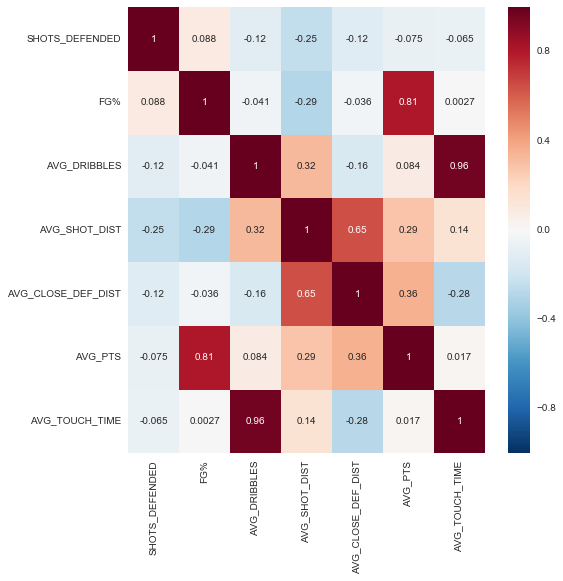

In [24]:
plt.figure(figsize=(8,8))
sns.heatmap(correlations, annot=True)

The above heatmap shows several interesting points.  Some significant insights include:
 - Worse defenders have a slightly higher chance of a shot being taken on them (shots defended versus FG%)
     - This is a broad generalization with a large assumption
 - The further away the shot is, the less chance of it going in (ok this is obvious)
 - The more dribbles, the further away the shot is likely to be from the basket
 - There is no siginificant relation between touch time of the basketball or dribbles and the chance the shot goes in
     - Perhaps this is because a lot of dribbles means not a 3 pt shot, so it evens out a little there
 - More dribbles means a defender was closer to the shot
 - Further away shots have further away defenders
 - The further away the shot, the more points are scored (although FG% goes down)
 - The further away the defender is, the more points scored (although FG% is not correlated with this)
 - The longer the ball is held by an offensive player, the closer the defender gets for the shot
 
While these are mostly broad generalizations, I believe they still offer some insight to the NBA game.

# Offensive Analysis

In [25]:
shooter_df = pd.concat([shots_ds['player_id'], shots_ds['player_name']], axis=1, keys=['player_id', 'name'])
shooter_df = shooter_df.drop_duplicates()

In [26]:
t_df = shots_ds.groupby('player_id').count()[['GAME_ID']]
t_df.reset_index(level=0, inplace=True)
t_df.rename(columns={'GAME_ID':'SHOTS_TAKEN'}, inplace=True)
shooter_df = shooter_df.merge(t_df, on='player_id')

In [27]:
t_df = shots_ds.groupby('player_id').sum()[['DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST', 'FGM', 'PTS', 'PTS_TYPE', 'PERIOD', 'SHOT_NUMBER']]
t_df.reset_index(level=0, inplace=True)
t_df.rename(columns={'FGM':'SHOTS_MADE'}, inplace=True)
shooter_df = shooter_df.merge(t_df, on='player_id')

In [28]:
# Calculate column percentages
shooter_df['FG%'] = shooter_df['SHOTS_MADE']/shooter_df['SHOTS_TAKEN']
shooter_df['AVG_DRIBBLES'] = shooter_df['DRIBBLES']/shooter_df['SHOTS_TAKEN']
shooter_df['AVG_SHOT_DIST'] = shooter_df['SHOT_DIST']/shooter_df['SHOTS_TAKEN']
shooter_df['AVG_CLOSE_DEF_DIST'] = shooter_df['CLOSE_DEF_DIST']/shooter_df['SHOTS_TAKEN']
shooter_df['AVG_PTS'] = shooter_df['PTS']/shooter_df['SHOTS_TAKEN']
shooter_df['AVG_TOUCH_TIME'] = shooter_df['TOUCH_TIME']/shooter_df['SHOTS_TAKEN']
shooter_df['AVG_PTS_TYPE'] = shooter_df['PTS_TYPE']/shooter_df['SHOTS_TAKEN']
shooter_df['AVG_PERIOD'] = shooter_df['PERIOD']/shooter_df['SHOTS_TAKEN']
shooter_df['AVG_SHOT_NUMBER'] = shooter_df['SHOT_NUMBER']/shooter_df['SHOTS_TAKEN']

In [29]:
shooter_df

,player_id,name,SHOTS_TAKEN,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,SHOTS_MADE,PTS,PTS_TYPE,...,SHOT_NUMBER,FG%,AVG_DRIBBLES,AVG_SHOT_DIST,AVG_CLOSE_DEF_DIST,AVG_PTS,AVG_TOUCH_TIME,AVG_PTS_TYPE,AVG_PERIOD,AVG_SHOT_NUMBER
0,203148,brian roberts,372,1229,1343.7,6957.5,1767.0,149,347,897,...,1711,0.400538,3.303763,18.702957,4.750000,0.932796,3.612097,2.411290,2.666667,4.599462
1,202687,bismack biyombo,114,36,155.0,459.3,267.6,64,128,228,...,343,0.561404,0.315789,4.028947,2.347368,1.122807,1.359649,2.000000,2.359649,3.008772
2,2744,al jefferson,800,557,2101.8,7452.3,2423.9,382,766,1603,...,7230,0.477500,0.696250,9.315375,3.029875,0.957500,2.627250,2.003750,2.446250,9.037500
3,203469,cody zeller,355,139,449.5,3774.6,1582.4,165,331,711,...,1387,0.464789,0.391549,10.632676,4.457465,0.932394,1.266197,2.002817,2.281690,3.907042
4,202390,gary neal,459,1173,1454.5,8018.9,1700.3,168,384,1078,...,2631,0.366013,2.555556,17.470370,3.704357,0.836601,3.168845,2.348584,2.775599,5.732026
5,201945,gerald henderson,563,1044,1468.4,8197.1,2255.9,246,523,1222,...,3630,0.436945,1.854352,14.559680,4.006927,0.928952,2.608171,2.170515,2.477798,6.447602
6,202689,kemba walker,695,3457,3419.6,10313.4,2682.4,278,622,1596,...,6734,0.400000,4.974101,14.839424,3.859568,0.894964,4.920288,2.296403,2.541007,9.689209
7,203077,michael kidd-gilchrist,369,478,711.7,3530.7,1216.1,174,348,738,...,2004,0.471545,1.295393,9.568293,3.295664,0.943089,1.928726,2.000000,2.192412,5.430894
8,202362,lance stephenson,436,1290,1557.0,6210.1,1800.5,159,331,959,...,2615,0.364679,2.958716,14.243349,4.129587,0.759174,3.571101,2.199541,2.394495,5.997706
9,101107,marvin williams,318,92,369.7,6168.2,1850.0,140,341,810,...,1221,0.440252,0.289308,19.396855,5.817610,1.072327,1.162579,2.547170,2.380503,3.839623


In [30]:
# Only take shooters with significant number of shots
shooter_dfs = shooter_df[shooter_df.SHOTS_TAKEN > 200]

In [31]:
correlations = shooter_dfs[['SHOTS_TAKEN', 'FG%', 'AVG_DRIBBLES', 'AVG_SHOT_DIST', 'AVG_CLOSE_DEF_DIST', 'AVG_PTS', 'AVG_PTS_TYPE', 'AVG_PERIOD', 'AVG_SHOT_NUMBER', 'AVG_TOUCH_TIME']].corr()

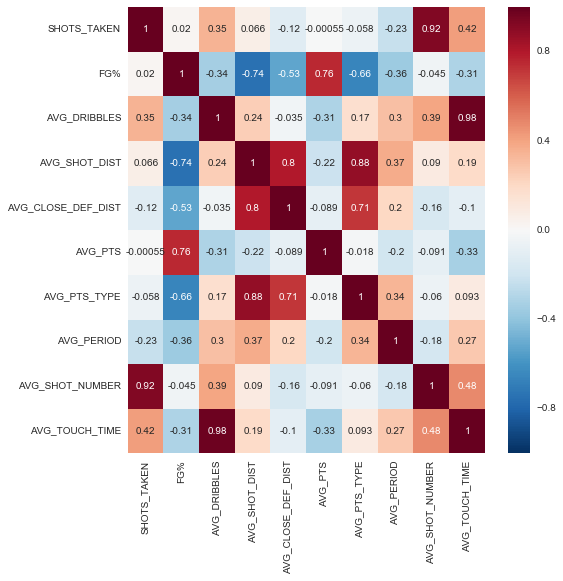

In [32]:
plt.figure(figsize=(8,8))
sns.heatmap(correlations, annot=True)

### Initial Insights

Here are some insights from the offensive analysis heatmap:
   - The more a player dribbles, the more likely they are to take more shots
   - The more shots taken, the defender will be slightly closer on average
   - The longer a shooter dribbles or holds the ball, the less chance of them making the field goal
       - This is probably related to the fact that ball handlers take more 3 pointers
   - The longer a shooter dribbles or holds the ball, the less points they're likely to have per shot
       - Interesting that the more that players possess the ball before a shot, the more shots they take, but the less their average points per shot is.  This is a sign that selfishness ruins offenses.
   - FG% is higher for those who shoot more in earlier periods
   - The further away the defender is, the higher the FG%
   - The more a shooter dribbles, the more shots they take later in the game
   - Further away shots are take by players who shoot later in the game
   - Defenders are likely to be further away from players who shoot later in the game


In [33]:
# Best percentage shooters
shooter_dfs.sort_values('FG%', ascending=False)[:20]

,player_id,name,SHOTS_TAKEN,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,SHOTS_MADE,PTS,PTS_TYPE,...,SHOT_NUMBER,FG%,AVG_DRIBBLES,AVG_SHOT_DIST,AVG_CLOSE_DEF_DIST,AVG_PTS,AVG_TOUCH_TIME,AVG_PTS_TYPE,AVG_PERIOD,AVG_SHOT_NUMBER
239,201599,deandre jordan,393,62,306.4,1343.2,1136.8,280,560,789,...,1629,0.712468,0.157761,3.417812,2.892621,1.424936,0.779644,2.007634,2.229008,4.145038
78,2199,tyson chandler,340,39,300.2,1404.4,1095.5,230,460,680,...,1442,0.676471,0.114706,4.130588,3.222059,1.352941,0.882941,2.000000,2.297059,4.241176
18,203497,rudy gobert,267,71,287.7,948.2,647.3,167,334,535,...,921,0.625468,0.265918,3.551311,2.424345,1.250936,1.077528,2.003745,2.430712,3.449438
74,201949,james johnson,311,579,820.2,2439.9,1085.5,191,392,663,...,1455,0.614148,1.861736,7.845338,3.490354,1.260450,2.637299,2.131833,2.565916,4.678457
22,202334,ed davis,350,124,424.5,1546.5,783.0,211,422,700,...,1360,0.602857,0.354286,4.418571,2.237143,1.205714,1.212857,2.000000,2.402857,3.885714
66,201582,alexis ajinca,211,82,298.9,1728.5,767.2,126,252,422,...,871,0.597156,0.388626,8.191943,3.636019,1.194313,1.416588,2.000000,2.616114,4.127962
273,203486,mason plumlee,403,223,616.8,1722.0,1135.5,236,472,809,...,1905,0.585608,0.553350,4.272953,2.817618,1.171216,1.530521,2.007444,2.292804,4.727047
162,203089,john henson,241,127,370.6,1197.4,641.4,140,280,482,...,948,0.580913,0.526971,4.968465,2.661411,1.161826,1.537759,2.000000,2.464730,3.933610
71,101161,amir johnson,402,209,558.6,2788.8,1243.2,233,480,838,...,1902,0.579602,0.519900,6.937313,3.092537,1.194030,1.389552,2.084577,2.365672,4.731343
203,2730,dwight howard,334,310,827.6,1404.7,798.5,192,385,670,...,2212,0.574850,0.928144,4.205689,2.390719,1.152695,2.477844,2.005988,2.242515,6.622754


In [34]:
# Best points per shot attempt
shooter_dfs.sort_values('AVG_PTS', ascending=False)[:20]

,player_id,name,SHOTS_TAKEN,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,SHOTS_MADE,PTS,PTS_TYPE,...,SHOT_NUMBER,FG%,AVG_DRIBBLES,AVG_SHOT_DIST,AVG_CLOSE_DEF_DIST,AVG_PTS,AVG_TOUCH_TIME,AVG_PTS_TYPE,AVG_PERIOD,AVG_SHOT_NUMBER
239,201599,deandre jordan,393,62,306.4,1343.2,1136.8,280,560,789,...,1629,0.712468,0.157761,3.417812,2.892621,1.424936,0.779644,2.007634,2.229008,4.145038
78,2199,tyson chandler,340,39,300.2,1404.4,1095.5,230,460,680,...,1442,0.676471,0.114706,4.130588,3.222059,1.352941,0.882941,2.000000,2.297059,4.241176
42,2594,kyle korver,478,140,499.8,10520.8,2391.2,235,646,1311,...,2388,0.491632,0.292887,22.010042,5.002510,1.351464,1.045607,2.742678,2.430962,4.995816
74,201949,james johnson,311,579,820.2,2439.9,1085.5,191,392,663,...,1455,0.614148,1.861736,7.845338,3.490354,1.260450,2.637299,2.131833,2.565916,4.678457
18,203497,rudy gobert,267,71,287.7,948.2,647.3,167,334,535,...,921,0.625468,0.265918,3.551311,2.424345,1.250936,1.077528,2.003745,2.430712,3.449438
22,202334,ed davis,350,124,424.5,1546.5,783.0,211,422,700,...,1360,0.602857,0.354286,4.418571,2.237143,1.205714,1.212857,2.000000,2.402857,3.885714
66,201582,alexis ajinca,211,82,298.9,1728.5,767.2,126,252,422,...,871,0.597156,0.388626,8.191943,3.636019,1.194313,1.416588,2.000000,2.616114,4.127962
71,101161,amir johnson,402,209,558.6,2788.8,1243.2,233,480,838,...,1902,0.579602,0.519900,6.937313,3.092537,1.194030,1.389552,2.084577,2.365672,4.731343
273,203486,mason plumlee,403,223,616.8,1722.0,1135.5,236,472,809,...,1905,0.585608,0.553350,4.272953,2.817618,1.171216,1.530521,2.007444,2.292804,4.727047
31,201939,stephen curry,968,3582,3786.8,16911.4,4370.7,470,1130,2392,...,9183,0.485537,3.700413,17.470455,4.515186,1.167355,3.911983,2.471074,2.359504,9.486570


In [35]:
# Don't let these players shoot it!
shooter_dfs.sort_values('AVG_PTS', ascending=True)[:20]

,player_id,name,SHOTS_TAKEN,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST,SHOTS_MADE,PTS,PTS_TYPE,...,SHOT_NUMBER,FG%,AVG_DRIBBLES,AVG_SHOT_DIST,AVG_CLOSE_DEF_DIST,AVG_PTS,AVG_TOUCH_TIME,AVG_PTS_TYPE,AVG_PERIOD,AVG_SHOT_NUMBER
225,201196,ramon sessions,219,848,908.1,2642.3,844.3,72,152,472,...,848,0.328767,3.872146,12.065297,3.855251,0.694064,4.146575,2.155251,2.598174,3.872146
8,202362,lance stephenson,436,1290,1557.0,6210.1,1800.5,159,331,959,...,2615,0.364679,2.958716,14.243349,4.129587,0.759174,3.571101,2.199541,2.394495,5.997706
136,101126,nate robinson,202,864,886.1,3571.3,882.6,69,162,496,...,897,0.341584,4.277228,17.679703,4.369307,0.801980,4.386634,2.455446,2.722772,4.440594
171,1713,vince carter,283,351,598.5,5526.9,1313.8,94,232,726,...,1249,0.332155,1.240283,19.529682,4.642403,0.819788,2.114841,2.565371,2.621908,4.413428
156,203487,michael carter-williams,657,2906,3105.0,8089.3,2211.4,253,539,1446,...,5586,0.385084,4.423135,12.312481,3.365906,0.820396,4.726027,2.200913,2.462709,8.502283
21,977,kobe bryant,713,2492,3301.9,11718.0,2307.9,266,586,1610,...,8402,0.373072,3.495091,16.434783,3.236886,0.821879,4.630996,2.258065,2.507714,11.784011
28,203135,robert sacre,242,176,514.6,2600.2,937.5,100,200,484,...,881,0.413223,0.727273,10.744628,3.873967,0.826446,2.126446,2.000000,2.520661,3.640496
23,101179,ronnie price,223,644,778.6,3913.9,978.5,77,185,555,...,826,0.345291,2.887892,17.551121,4.387892,0.829596,3.491480,2.488789,2.466368,3.704036
92,203901,elfrid payton,480,2836,2651.7,3761.2,1518.7,198,400,982,...,2491,0.412500,5.908333,7.835833,3.163958,0.833333,5.524375,2.045833,2.558333,5.189583
4,202390,gary neal,459,1173,1454.5,8018.9,1700.3,168,384,1078,...,2631,0.366013,2.555556,17.470370,3.704357,0.836601,3.168845,2.348584,2.775599,5.732026


In [36]:
avg_cols = [col for col in shooter_dfs.columns if 'AVG' in col]
shooter_dfs[avg_cols].describe()

,AVG_DRIBBLES,AVG_SHOT_DIST,AVG_CLOSE_DEF_DIST,AVG_PTS,AVG_TOUCH_TIME,AVG_PTS_TYPE,AVG_PERIOD,AVG_SHOT_NUMBER
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,1.817978,13.453408,4.148962,0.997638,2.565494,2.267168,2.478270,5.892149
std,1.639703,4.221463,0.752839,0.094501,1.307230,0.202472,0.167156,1.893100
min,0.114706,2.609667,2.237143,0.694064,0.779644,2.000000,2.071130,2.963563
25%,0.601507,10.609767,3.668598,0.940872,1.608000,2.039679,2.358730,4.423727
50%,1.104905,14.226085,4.186313,0.987421,2.092024,2.278521,2.467441,5.435888
75%,2.893562,16.697884,4.676105,1.049598,3.423808,2.426457,2.592688,7.179520
max,5.978531,22.062379,5.873684,1.424936,5.994802,2.742678,2.969828,12.175439


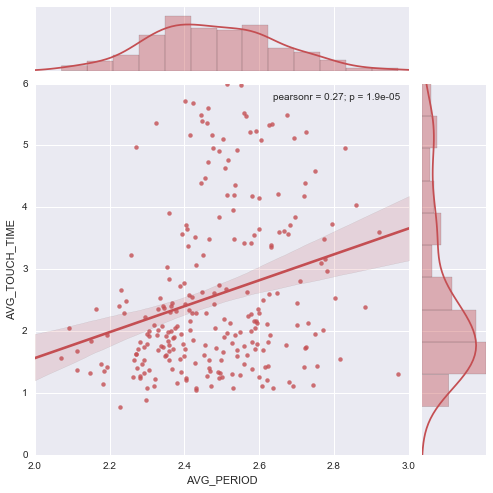

In [37]:
sns.set(style="darkgrid", color_codes=True)
g = sns.jointplot("AVG_PERIOD", "AVG_TOUCH_TIME", data=shooter_dfs[['AVG_PERIOD', 'AVG_TOUCH_TIME']], kind="reg",
                  xlim=(2, 3), ylim=(0, 6), color="r", size=7)

In [38]:
shots_ds.head()

,GAME_ID,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,...,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id,date,team1,team2
0,21400899,A,W,24,1,1,1:09,10.8,2,1.9,...,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148,"MAR 04, 2015",CHA,BKN
1,21400899,A,W,24,2,1,0:14,3.4,0,0.8,...,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148,"MAR 04, 2015",CHA,BKN
2,21400899,A,W,24,3,1,0:00,NaN,3,2.7,...,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148,"MAR 04, 2015",CHA,BKN
3,21400899,A,W,24,4,2,11:47,10.3,2,1.9,...,"Brown, Markel",203900,3.4,0,0,brian roberts,203148,"MAR 04, 2015",CHA,BKN
4,21400899,A,W,24,5,2,10:34,10.9,2,2.7,...,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148,"MAR 04, 2015",CHA,BKN


In [39]:
def convert_game_clock(time):
    mi, sec = time.split(':')
    mi = int(mi)/12.0
    sec = int(sec)/60.0/12.0
    return mi+sec

In [40]:
shots_ds['converted_game_clock'] = shots_ds.GAME_CLOCK.apply(convert_game_clock)

In [41]:
shots_ds['period_and_time'] = shots_ds['PERIOD'] + shots_ds['converted_game_clock']

In [42]:
shots_ds['PERIOD'].unique()

array([1, 2, 4, 3, 5, 6, 7])

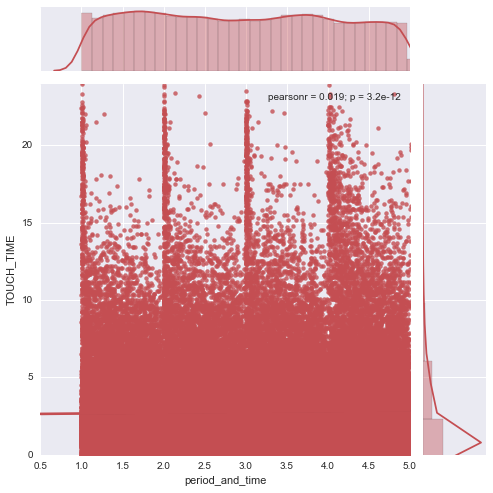

In [97]:
sns.set(style="darkgrid", color_codes=True)

g = sns.jointplot("period_and_time", "TOUCH_TIME", data=shots_ds, kind="reg",
                  xlim=(.5, 5), ylim=(0, 24), color="r", size=7)

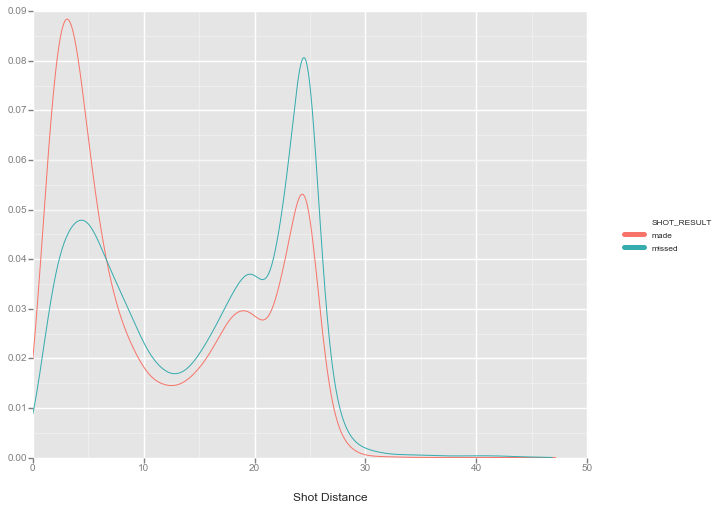

<ggplot: (307408549)>

In [55]:
ggplot(shots_ds, aes(x='SHOT_DIST', color='SHOT_RESULT', group='SHOT_RESULT')) + \
  geom_density() +\
  xlab("Shot Distance") + ylab("")

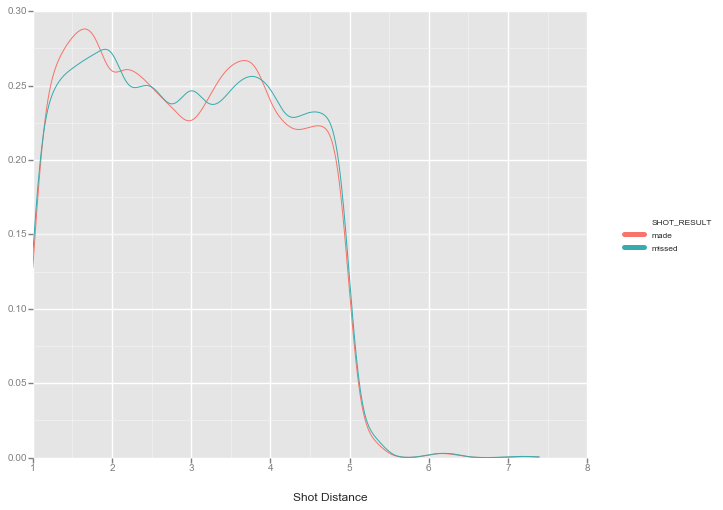

<ggplot: (307408477)>

In [56]:
ggplot(shots_ds, aes(x='period_and_time', color='SHOT_RESULT', group='SHOT_RESULT')) + \
  geom_density() +\
  xlab("Shot Distance") + ylab("")

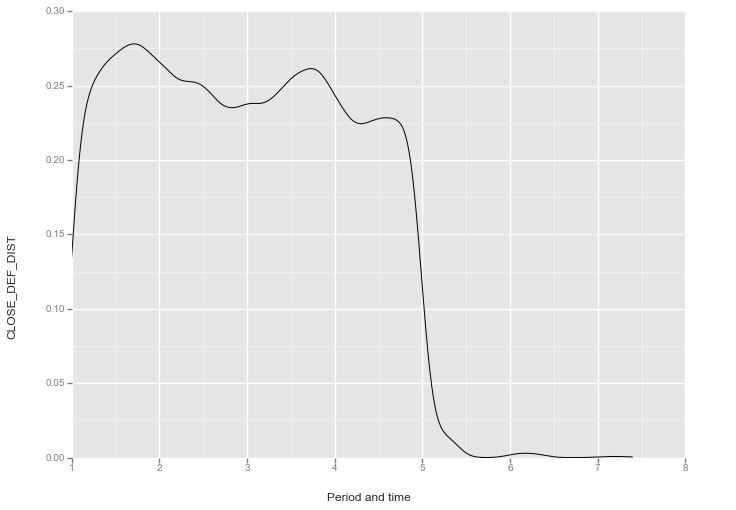

<ggplot: (304185497)>

In [75]:
ggplot(shots_ds, aes(x='period_and_time', y='CLOSE_DEF_DIST')) + \
  geom_density() +\
  xlab("Period and time") + ylab("")

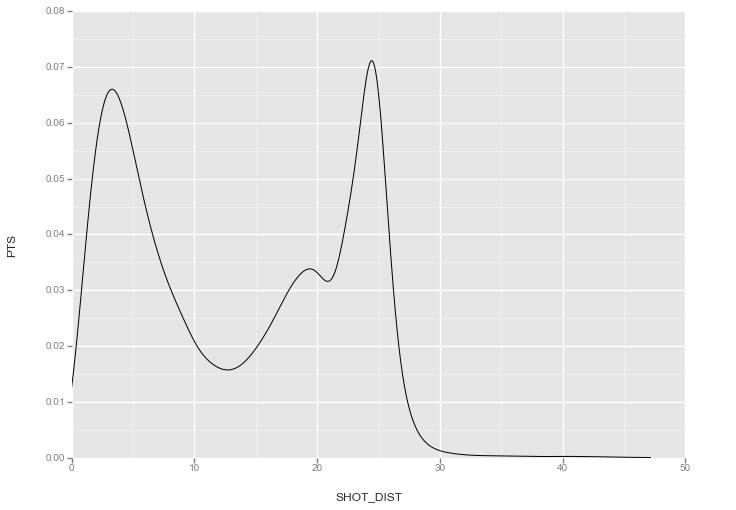

<ggplot: (307478241)>

In [92]:
ggplot(shots_ds, aes(x='SHOT_DIST', y='PTS')) + \
  geom_density()

# Conclusion

NBA teams should stop shooting free throw range shots.  As is visible on the graph above, either shoot close shots or threes.